In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\91934\Downloads\NLP_D1_C1\ML471_S1_Datafile_Concept.csv")
df.head()

,DATE,Consumption,Festivals/Special_events
0,01-01-1988,107.5052,6
1,02-01-1988,105.6720,1
2,03-01-1988,97.4502,1
3,04-01-1988,92.4714,1
4,05-01-1988,90.3151,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATE                      397 non-null    object 
 1   Consumption               397 non-null    float64
 2   Festivals/Special_events  397 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 9.4+ KB


In [4]:
df['Datetime'] = pd.to_datetime(df['DATE'])
df.head()

,DATE,Consumption,Festivals/Special_events,Datetime
0,01-01-1988,107.5052,6,1988-01-01
1,02-01-1988,105.6720,1,1988-02-01
2,03-01-1988,97.4502,1,1988-03-01
3,04-01-1988,92.4714,1,1988-04-01
4,05-01-1988,90.3151,1,1988-05-01


In [5]:
df.set_index('Datetime', inplace = True)

In [6]:
#Rename Column
df = df.groupby('Datetime').sum('Consumption')
print(df.head(7))

            Consumption  Festivals/Special_events
Datetime                                         
1988-01-01     107.5052                         6
1988-02-01     105.6720                         1
1988-03-01      97.4502                         1
1988-04-01      92.4714                         1
1988-05-01      90.3151                         1
1988-06-01      93.0904                         1
1988-07-01      97.6202                         0


In [7]:
#Check if data is sorted by the datetime column
#Important in time series
is_sorted = df.index.is_monotonic_increasing
print(f"Is data sorted chronologically ? {is_sorted}")

#Sort the data by the datetime index
#is already true here, but sorting for understanding

df = df.sort_index()

#Verify the data is now sorted
is_sorted = df.index.is_monotonic_increasing
print(is_sorted)

Is data sorted chronologically ? True
True


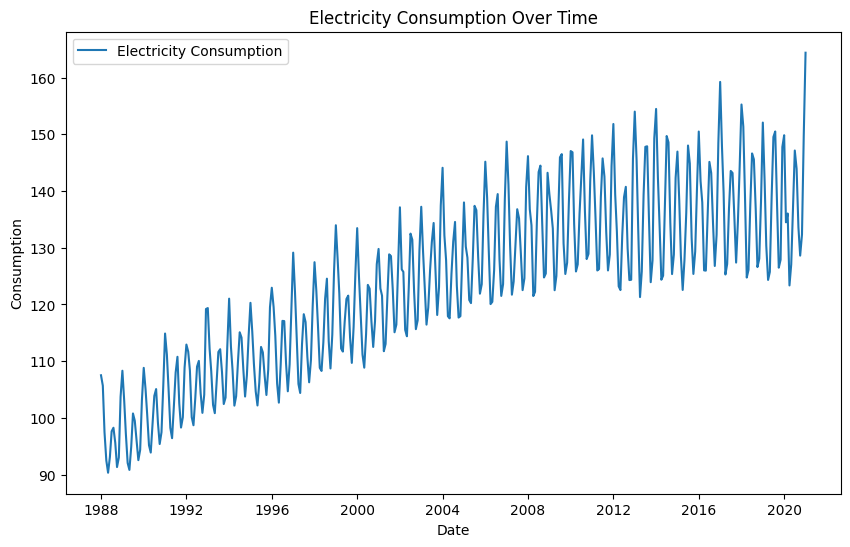

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
plt.plot(df['Consumption'], label = 'Electricity Consumption')
plt.title('Electricity Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()
plt.show()

In [9]:
df.isna().sum()

Consumption                 0
Festivals/Special_events    0
dtype: int64

In [10]:
# Handle outliers by capping values beyond 3 standard deviations
mean = df['Consumption'].mean()
std_dev = df['Consumption'].std()
threshold = 3
# Corrected line: Keep values within 3 standard deviations from the mean
df = df[(df['Consumption'] > mean - threshold * std_dev) & (df['Consumption'] < mean + threshold * std_dev)]


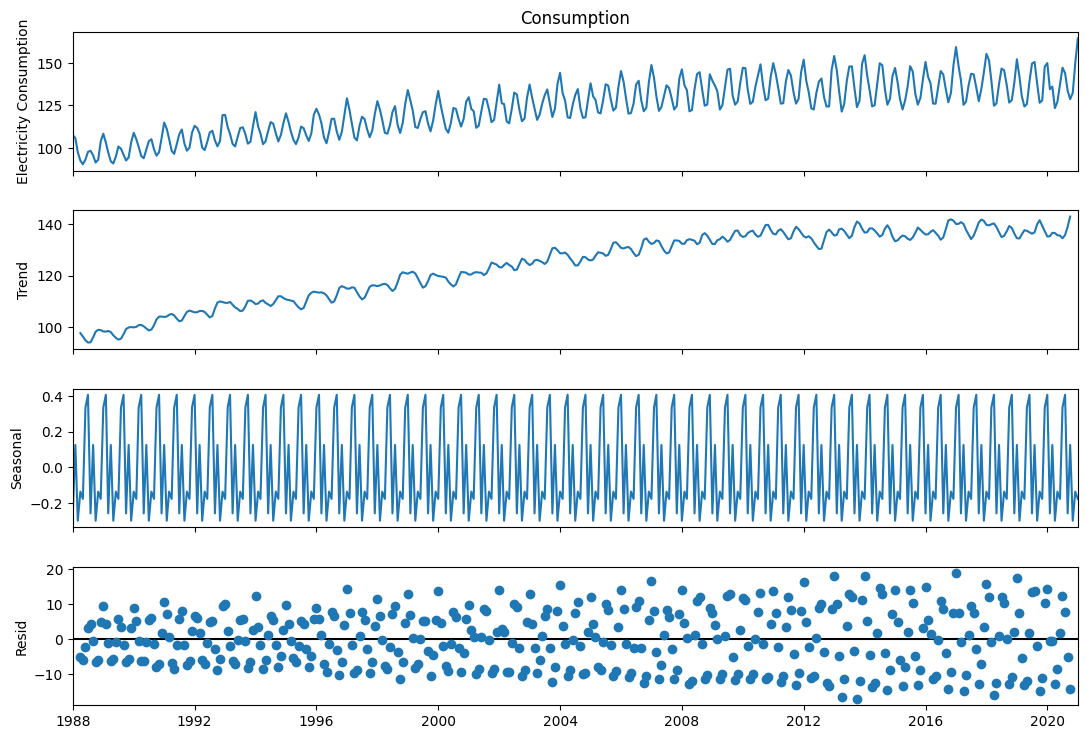

In [11]:
# Decompose the data using the additive model
from statsmodels.tsa.seasonal import seasonal_decompose
additive_decomposition = seasonal_decompose(df['Consumption'], model='additive', period=7)  # For Weekly Patterns (Period = 7)

# Plot the decomposition results
fig = additive_decomposition.plot()
fig.set_size_inches(12, 8)
# Add a y-axis label to the first graph
fig.axes[0].set_ylabel("Electricity Consumption")
plt.show()

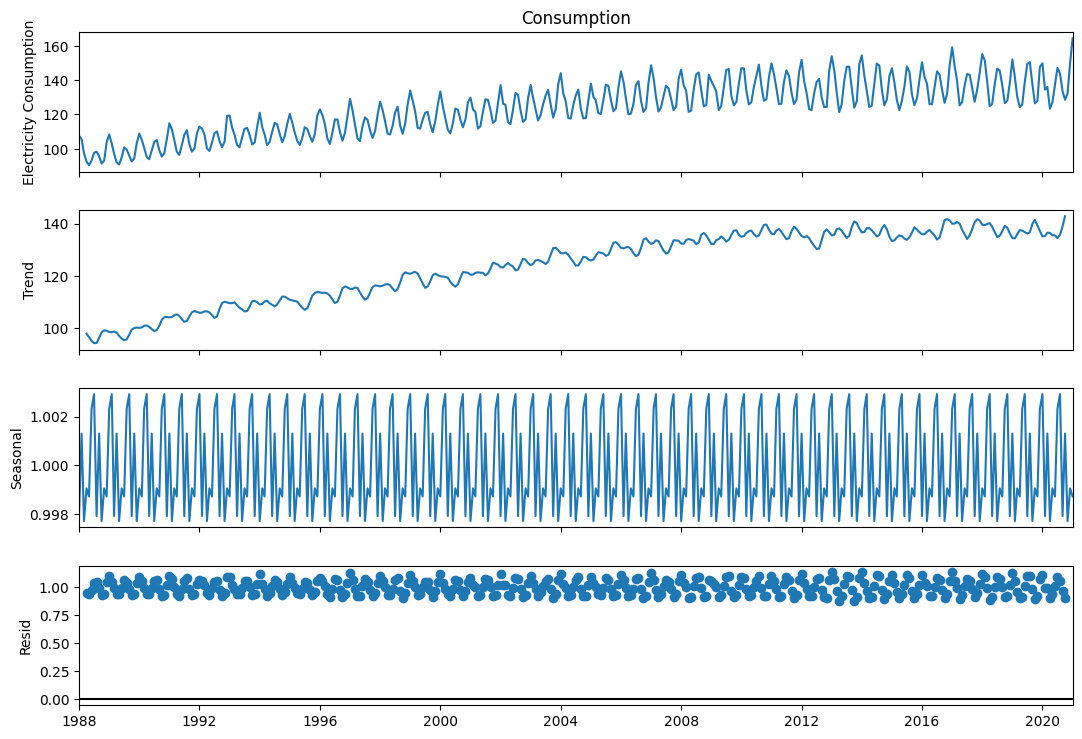

In [12]:
# Decompose the data using the multiplicative model
multiplicative_decomposition = seasonal_decompose(df['Consumption'], model='multiplicative', period=7)

# Plot the decomposition results
fig=multiplicative_decomposition.plot()
fig.set_size_inches(12, 8)
# Add a y-axis label to the first graph
fig.axes[0].set_ylabel("Electricity Consumption")
plt.show()

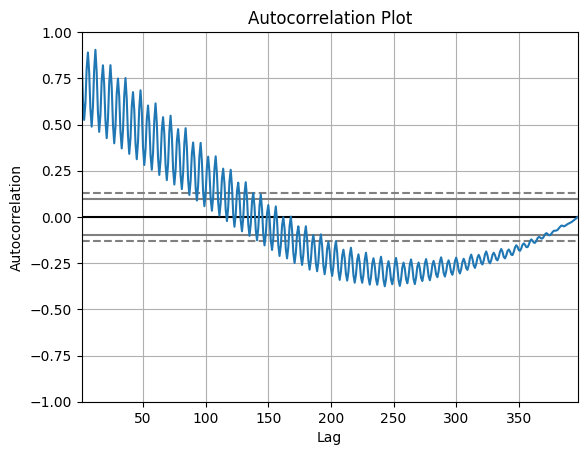

In [13]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Consumption'])
plt.title('Autocorrelation Plot')
plt.show()


ADF test on Original Data:
ADF Statistic: -2.256990350047131
p-value: 0.1862146911659065
Series is non-stationary (fail to reject null hypothesis).


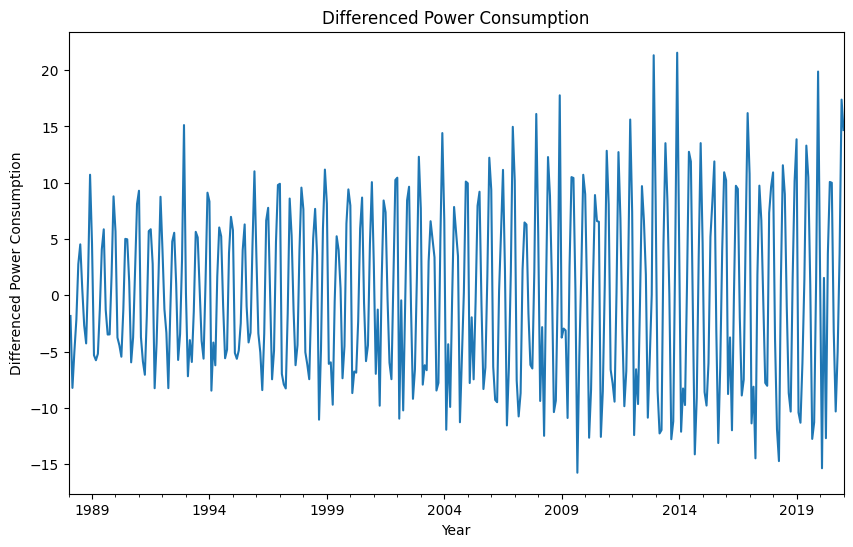

In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())  # drop NaN values
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print("Series is stationary (reject null hypothesis).")
    else:
        print("Series is non-stationary (fail to reject null hypothesis).")
# Run the ADF test on original data
print("ADF test on Original Data:")
adf_test(df['Consumption'])
# First-order differencing (subtract each value by the previous one)
df['Power_Consumption_diff'] = df['Consumption'].diff()

# Visualize the differenced data
df['Power_Consumption_diff'].plot(title='Differenced Power Consumption', figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Differenced Power Consumption')
plt.show()

In [15]:
# Perform the ADF test again on the differenced data
print("\nADF test on Differenced Data:")
adf_test(df['Power_Consumption_diff'])


ADF test on Differenced Data:
ADF Statistic: -7.104890882267328
p-value: 4.077786565539053e-10
Series is stationary (reject null hypothesis).


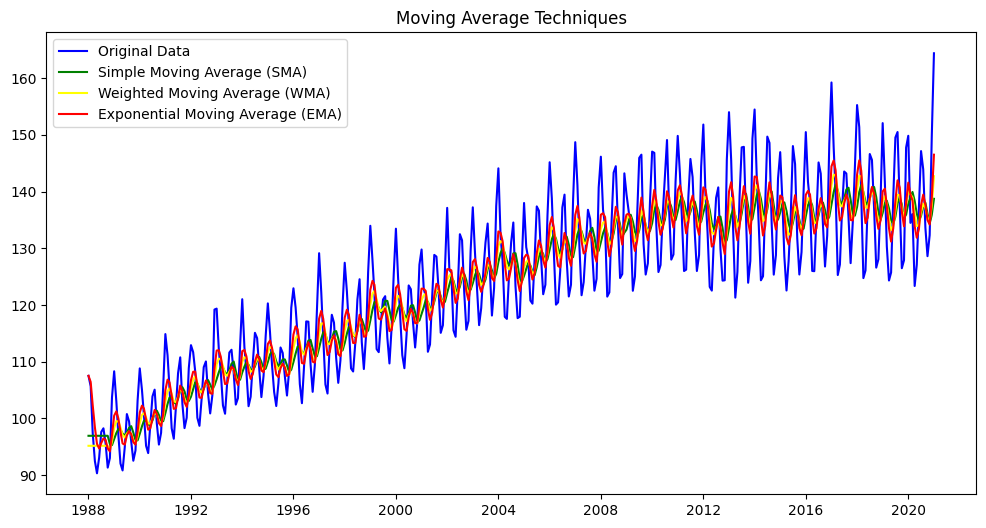

In [23]:
import numpy as np

# 1. Simple Moving Average (SMA)
sma = df["Consumption"].rolling(window=10).mean().bfill()  # Use a window of 10

# 2. Weighted Moving Average (WMA)
weights = np.arange(1, 11)  # Assign weights for the last 10 values
wma = df["Consumption"].rolling(window=10).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True).bfill()

# 3. Exponential Moving Average (EMA)
ema = df["Consumption"].ewm(alpha=0.3).mean().bfill()  # Smoothing factor alpha = 0.3

# Plot Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df["Consumption"], label="Original Data", color="blue")
plt.plot(sma, label="Simple Moving Average (SMA)", color="green")
plt.plot(wma, label="Weighted Moving Average (WMA)", color="yellow")
plt.plot(ema, label="Exponential Moving Average (EMA)", color="red")
plt.legend()
plt.title("Moving Average Techniques")
plt.show()

In [27]:
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import pandas as pd

# Ensure datetime index with frequency
df.index = pd.to_datetime(df.index)


# 1. Single Exponential Smoothing (SES)
ses_model = SimpleExpSmoothing(df["Consumption"]).fit(optimized=True)
ses = ses_model.fittedvalues.bfill()

# 2. Double Exponential Smoothing (Holt)
holt_model = ExponentialSmoothing(
    df["Consumption"], trend="add"
).fit(
    smoothing_level=0.5,
    smoothing_trend=0.2,
    optimized=False
)
holt = holt_model.fittedvalues.bfill()

# 3. Triple Exponential Smoothing (Holt-Winters)
holt_winters_model = ExponentialSmoothing(
    df["Consumption"],
    trend="add",
    seasonal="add",
    seasonal_periods=12
).fit()

holt_winters = holt_winters_model.fittedvalues.bfill()


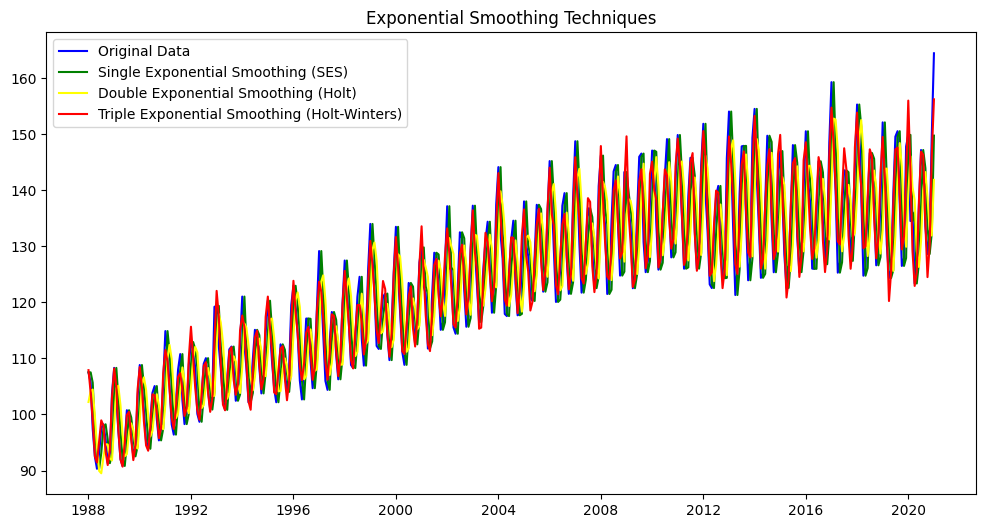

In [28]:
# Plot Exponential Smoothing Techniques
plt.figure(figsize=(12, 6))
plt.plot(df["Consumption"], label="Original Data", color="blue")
plt.plot(ses, label="Single Exponential Smoothing (SES)", color="green")
plt.plot(holt, label="Double Exponential Smoothing (Holt)", color="yellow")
plt.plot(holt_winters, label="Triple Exponential Smoothing (Holt-Winters)", color="red")
plt.legend()
plt.title("Exponential Smoothing Techniques")
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error

def optimize_params_exp_smooth(data):

    alphas = [0.1, 0.2, 0.5, 0.8]
    betas = [0.1, 0.2, 0.5]
    gammas = [0.1, 0.2, 0.5]

    best_rmse = float("inf")
    best_params = {}

    for alpha in alphas:
        for beta in betas:
            for gamma in gammas:
                try:
                    model = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=7).fit(
                        smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma
                    )

                    rmse = np.sqrt(mean_squared_error(data, model.fittedvalues))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = {"alpha": alpha, "beta": beta, "gamma": gamma}
                except Exception as e:
                    print(f"Error with alpha={alpha}, beta={beta}, gamma={gamma}: {e}")

    if best_params:
        print("Best Parameters:", best_params)
        print("Best RMSE:", best_rmse)
    else:
        print("No valid parameter combination found.")
    return best_params

best_params = optimize_params_exp_smooth(df["Consumption"])

C:\Users\91934\AppData\Local\Temp\ipykernel_9892\2630876163.py:16: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=7).fit(
C:\Users\91934\AppData\Local\Temp\ipykernel_9892\2630876163.py:16: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=7).fit(
C:\Users\91934\AppData\Local\Temp\ipykernel_9892\2630876163.py:16: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=7).fit(
C:\Users\91934\AppData\Local\Temp\ipykernel_9892\2630876163.py:16: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=7).fit(
C:\U

Best Parameters: {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.5}
Best RMSE: 7.536608067280814


C:\Users\91934\AppData\Local\Temp\ipykernel_9892\2630876163.py:16: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=7).fit(
C:\Users\91934\AppData\Local\Temp\ipykernel_9892\2630876163.py:16: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=7).fit(
C:\Users\91934\AppData\Local\Temp\ipykernel_9892\2630876163.py:16: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=7).fit(


In [32]:
# Finding the best smoothing technique
from sklearn.metrics import mean_squared_error
methods = {
    'SMA': sma, 'EMA': ema, 'WMA': wma,
    'SES': ses, 'Holt': holt, 'Holt-Winters': holt_winters
}

rmse_values = {}
for method, smoothed_data in methods.items():
    smoothed_data = smoothed_data[:len(df)]
    rmse = np.sqrt(mean_squared_error(df["Consumption"], smoothed_data))
    rmse_values[method] = rmse

print("RMSE for each smoothing method:")
for method, rmse in rmse_values.items():
    print(f"{method}: {rmse:.4f}")

best_method = min(rmse_values, key=rmse_values.get)
print(f"\nBest smoothing method is {best_method} with RMSE of {rmse_values[best_method]:.4f}.")

RMSE for each smoothing method:
SMA: 7.9610
EMA: 6.0238
WMA: 7.0358
SES: 7.7462
Holt: 9.6600
Holt-Winters: 2.5215

Best smoothing method is Holt-Winters with RMSE of 2.5215.
